#Introduction

Human action recognition (HAR)

In [3]:
! pip install tensorflow-addons

#Import Libraries and Load the dataset to Python Notebook and preprocess


In [4]:
#import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from  IPython import display
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import time
import pathlib
import shutil
import tempfile
import tensorflow as tf
import tensorflow.keras as keras
from scipy.interpolate import interp1d
import numpy as np
from scipy.ndimage.interpolation import rotate, shift
from PIL import Image
import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

In [5]:
#GPU setting as processing unit
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
#Loading dataset
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
#Unzip dataset folder
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/A1_data/Images.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

The read_csv() function loads the input file, which which is a csv formatted file delimited by comma, into a pandas dataframe.

In [8]:
image_path = './Images/'
train_data = pd.read_csv('/content/drive/MyDrive/A1_data/S40AR_train_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/A1_data/S40AR_test_data.csv')

In [95]:
test_data.head()

,FileName
0,Img_1005.jpg
1,Img_1012.jpg
2,Img_1014.jpg
3,Img_1015.jpg
4,Img_102.jpg


In [9]:
train_data.head(5)

,FileName,action,action_class
0,Img_1000.jpg,walking_the_dog,Interacting_with_animal
1,Img_1001.jpg,riding_a_bike,other_activity
2,Img_1002.jpg,gardening,domestic_work
3,Img_1008.jpg,cooking,domestic_work
4,Img_1010.jpg,jumping,other_activity


#Exploratory Data Analysis (EDA)
EDA is a critical process to perform initial investigations on data to gain maximize insight, examine the underlying data structure
with the help of graphical representations.


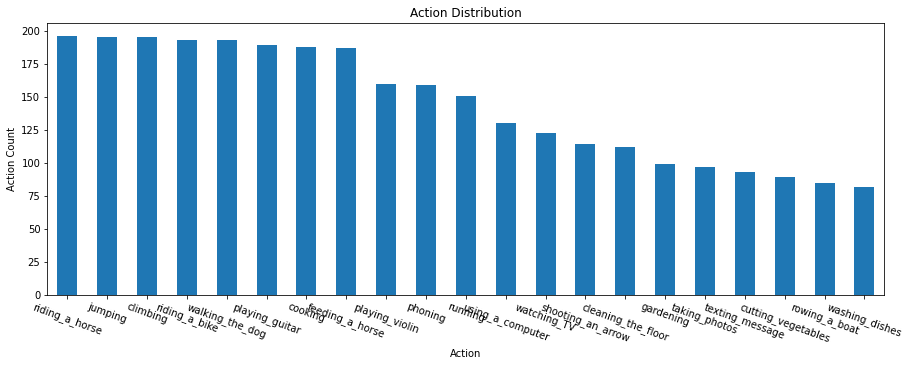

In [10]:
#Exploratory Data Analysis (EDA)
train_data.action.value_counts().plot(kind ='bar',rot = -20,figsize=(15,5),title ='Action Distribution',xlabel='Action', ylabel ='Action Count')

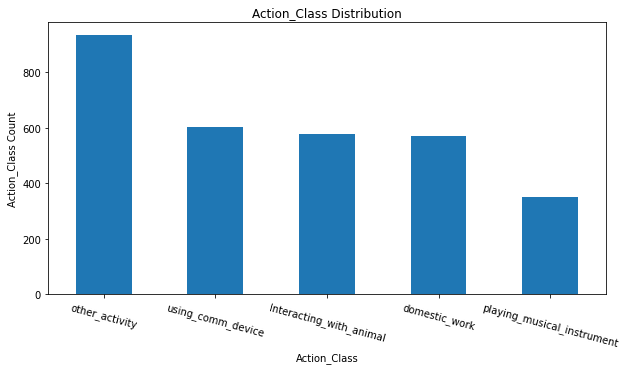

In [11]:
#action_class distribution
train_data.action_class.value_counts().plot(kind ='bar',rot = -15,figsize=(10,5),title ='Action_Class Distribution',xlabel='Action_Class', ylabel ='Action_Class Count')

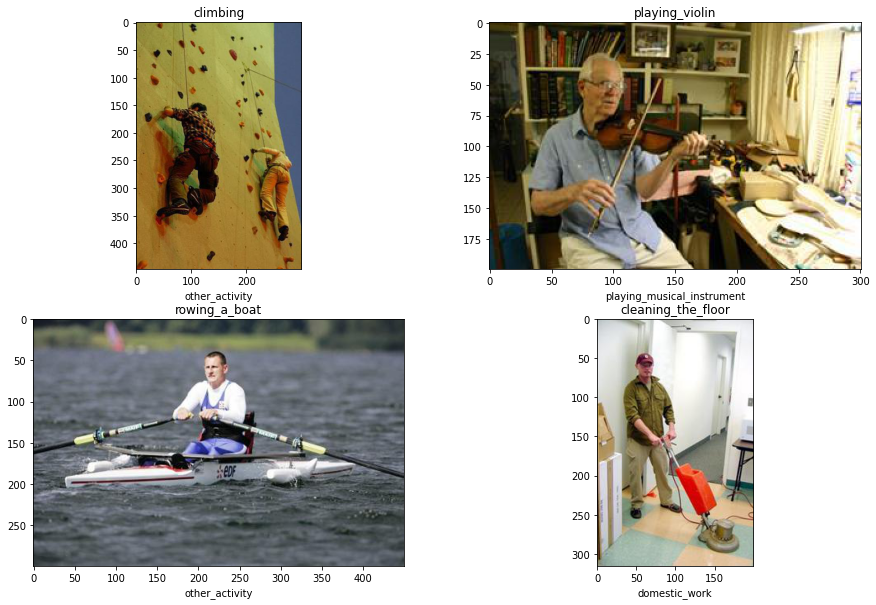

In [12]:
plt.figure(figsize=(15,10))
i=1
for index,row in train_data.sample(n=4).iterrows():
  plt.subplot(2,2,i)
  image = plt.imread(str("./Images/"+row.FileName))
  plt.imshow(image)
  plt.title(row.action)
  plt.xlabel(row.action_class)
  i=i+1

Observation from above EDA class distribution
.It can be observe that both 'action' and 'action_class' are imbalanced .Evaluation Metric/ performance measure- to handle the imbalance data , i am going to use macro average F1 score.
 I am going to use Accuracy and confucion matrix to investigate under fitting and overfitting, True Positive(TP), False Positives(FP), True Negatives(TN) and False Negatives values.

In [13]:
#Lable Encoding for action and action_class labels
actionEncoder = LabelEncoder()
action_classEncoder = LabelEncoder()
train_data.insert(2,'action_en',actionEncoder.fit_transform(train_data['action'])) 
train_data.insert(4,'action_class_en',action_classEncoder.fit_transform(train_data['action_class']))


In [14]:
train_data.head(5)

,FileName,action,action_en,action_class,action_class_en
0,Img_1000.jpg,walking_the_dog,18,Interacting_with_animal,0
1,Img_1001.jpg,riding_a_bike,10,other_activity,2
2,Img_1002.jpg,gardening,5,domestic_work,1
3,Img_1008.jpg,cooking,2,domestic_work,1
4,Img_1010.jpg,jumping,6,other_activity,2


In [15]:
#Confusion matrix

def set_conf_metric(output_class):
  if(output_class == 'action'):
    METRICS = [tfa.metrics.F1Score(num_classes=21,average='macro'), tf.keras.metrics.CategoricalAccuracy(name='accuracy'),]
    return METRICS
  elif(output_class == 'action_class'):
    METRICS = [tfa.metrics.F1Score(num_classes=5,average='macro'), tf.keras.metrics.CategoricalAccuracy(name='accuracy'),]
    return METRICS

# confusion matrix plot
def show_conf_metric(labels, predictions):
  conf = confusion_matrix(labels, predictions)
  plt.figure(figsize=(15,8))
  sns.heatmap(conf, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}')
  plt.ylabel('Actual labels')
  plt.xlabel('Predicted labels')

In [16]:
# method for plotting learning curve
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

##Spliiting Data

I am going to use stratify random data splitting to balance out the equal proportion of all the action class lables.

In [17]:
#splitting up the data by using stratified technique
train_D, test_D = train_test_split(train_data, test_size=0.3,shuffle=True, stratify= train_data['action'],random_state=42)
train_D, val_D = train_test_split(train_D, test_size=0.25, shuffle=True, stratify= train_D['action'],random_state=42)

print("Train data : {}, Test Data: {}, Val Data: {}".format(train_D.shape[0], test_D.shape[0], val_D.shape[0]))

Train data : 1590, Test Data: 909, Val Data: 531


## Datagenerator/Dataloader
I have used custom datageanrator for this assignment to predict the output of two classes trained in a single CNN model.
To avoid overfitting, Data augmentation techniques has been used.

In [18]:
#Datagenerator/Dataloader
#Custom defined data loader
'We will be using this generator for various setting and will select appropriate parameters'
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=8, dim=(224,224,3), data_mean=0, data_std=255.0,  data_prefix='', shuffle=True, Augment=True, with_labels = True):
        'Initialization'
        self.data_frame = data_frame
        self.dim = dim  # Dimentions of the input
        self.withLabels = with_labels
        self.batch_size = batch_size
        self.n_classes_action = 21  # Number of classes for action 
        self.n_classes_action_class = 5  # Number of classes for action classes label

        self.shuffle = shuffle  # Flag to shuffle data at the end of epoch
        self.Augment = Augment  # Falg to augmetn the data

        # The data is input as a pandas dataframe, we need to read the relevent fields

        self.image_action_label = data_frame['action_en'].values.tolist() 
        self.image_action_class_label = data_frame['action_class_en'].values.tolist() 

        self.image_ids = np.arange(len(self.image_action_label)).tolist() 
        self.data_prefix = data_prefix
        
        # Data normalization parameters
        self.data_mean = data_mean
        self.data_std = data_std
        
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data for the given index'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        data_ids_temp = [self.image_ids[k] for k in indexes]
        image_action_label_temp = [self.image_action_label[k] for k in indexes]
        image_action_class_label_temp = [self.image_action_class_label[k] for k in indexes]
        # Generate data
        X, y_action,y_actionC = self.__data_generation(data_ids_temp, image_action_label_temp,image_action_class_label_temp)
        
        return X, {'action':y_action,'action_class':y_actionC}

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
        
    # Support function

    def __data_generation(self, data_ids_temp, image_action_label_temp,image_action_class_label_temp):
        'Generates data containing batch_size samples' 

        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y_action = np.empty((self.batch_size), dtype=int)
        y_actionC = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, ids in enumerate(data_ids_temp):
            
            X[i,] = self.__read_data_instance(data_ids_temp[i])
            y_action[i] = image_action_label_temp[i]
            y_actionC[i] = image_action_class_label_temp[i]
            
        return X, keras.utils.to_categorical(y_action, num_classes=self.n_classes_action),keras.utils.to_categorical(y_actionC, num_classes=self.n_classes_action_class)


    def __read_data_instance(self, pid):
      # Read an image
      filepath = self.data_prefix + self.data_frame.iloc[pid]['FileName']
      if(filepath == './Images/Img_3201.jpg'):
        return
      data = Image.open(filepath)  

      data = data.resize((224,224))
     
      data = np.asarray(data)

      if self.Augment:
        
        fliprl = np.random.rand(1) < 0.5 # Randomly flipignthe image left-right
        if fliprl:
          data = np.fliplr(data)
        rot = np.random.rand(1) < 0.5 # Randomly rotating the image
        if rot:
            rot = np.random.randint(-10,10, size=1)
            data = rotate(data, angle=rot[0], reshape=False)
        shiftimg = np.random.rand(1) <0.5 # Randomly shifting the image
        if shiftimg:
            shift_val = np.random.randint(-5, high=5, size=2, dtype=int).tolist() + [0,]
            data = shift(data, shift_val, order=0, mode='constant', cval=0.0, prefilter=False)

      X = data

      # Input normalization
      # X = (X - self.data_mean)/self.data_std
      return X

In [19]:
prefix='./Images/'
batchsize = 32
training_generator = DataGenerator(train_D, batch_size=batchsize,Augment=True, data_prefix=prefix)
testing_generator = DataGenerator(test_D, batch_size=1, shuffle=False, Augment = False, data_prefix=prefix)
validation_generator = DataGenerator(val_D, batch_size=batchsize,Augment=False, data_prefix=prefix)


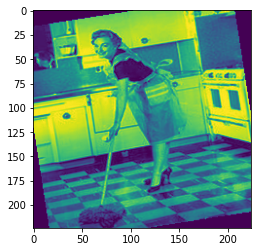

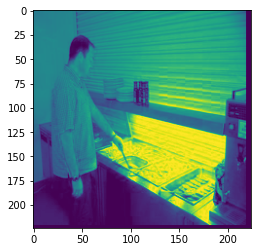

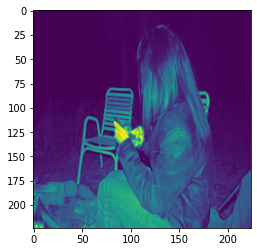

In [20]:
#visualise datagenerators
i=0
for inp,row in training_generator.__iter__():
  if i <3:
    plt.imshow(inp[0,:,:,0])
    plt.pause(.1)
    i=i+1
  else:
    break

In [68]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_action_accuracy', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

##BaseLine Model
For this Task, I've chosen VGG-16 as basline model. VGG 16 is the simpler and easy to implement pre-trained model for image classification.

I have used pretrained VGG16 model with pretrained imagenet weights .
SOFTMAX activation function is used in the output layer to get the probabilities for the classes where probablities add up to 1.
 I have used include_top=False as i do not want my model to train on all the network layers.

##Objective
objective of this assigmnet to develop an efficient deep convolutional neural network (CNN) to identify the actions of a person from still image in single pretrained model. I am aiming to achieve around 90% accuracy and F1 score with comaprision of state-of-art CNN models to investigate which model performes well with respect to this assignment.

Optimizer and Loss Function
Adam optimizer
categorical_crossentropy

In [22]:
#Base line model VGG16
# VGG16
# Parameter initialization
from tensorflow.keras.applications import VGG16
input_shape = (224, 224, 3)
base_model_lr = 0.001 #learning rate

base_model_1 = VGG16(input_shape=input_shape,include_top=False,weights='imagenet')
for layer in base_model_1.layers:
  base_model_1.trainable = False


preprocess_input = tf.keras.applications.vgg16.preprocess_input

inputs = tf.keras.Input(shape=input_shape)
x = preprocess_input(inputs)
x = base_model_1(x, training=True)
x = tf.keras.layers.Flatten()(x)

# x = tf.keras.layers.GlobalAveragePooling2D()(x)

#custom output dense layer for two classess
output_action = tf.keras.layers.Dense(21, activation='softmax',name='action')(x)
output_action_class = tf.keras.layers.Dense(5, activation='softmax', name = 'action_class')(x)

# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

base_model_2 = tf.keras.Model(inputs, [output_action,output_action_class])

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(base_model_lr,decay_steps=10000,decay_rate=10,staircase=False)

base_model_2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = lr_schedule),
              loss={
                  'action': "categorical_crossentropy", 
                  'action_class': "categorical_crossentropy"},
              metrics={
                  'action': set_conf_metric('action'),
                  'action_class': set_conf_metric('action_class')})

In [23]:
base_model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 224, 224, 3)  0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    tf.nn.bias_add[0][0]             
______________________________________________________________________________________________

In [24]:
m_histories = {}
m_histories['Base_model1'] = base_model_2.fit(training_generator,
                                                epochs = 15,verbose = 1,
                                                validation_data = validation_generator, callbacks = [early_stop])

Epoch 1/15
49/49 [==============================] - 55s 848ms/step - loss: 21.4644 - action_loss: 12.6611 - action_class_loss: 8.8033 - action_f1_score: 0.4874 - action_accuracy: 0.5230 - action_class_f1_score: 0.7350 - action_class_accuracy: 0.7366 - val_loss: 11.4829 - val_action_loss: 7.3224 - val_action_class_loss: 4.1605 - val_action_f1_score: 0.6898 - val_action_accuracy: 0.7148 - val_action_class_f1_score: 0.8369 - val_action_class_accuracy: 0.8418
Epoch 2/15
49/49 [==============================] - 41s 827ms/step - loss: 5.9099 - action_loss: 3.3844 - action_class_loss: 2.5255 - action_f1_score: 0.8106 - action_accuracy: 0.8278 - action_class_f1_score: 0.8847 - action_class_accuracy: 0.8858 - val_loss: 8.7021 - val_action_loss: 5.8397 - val_action_class_loss: 2.8625 - val_action_f1_score: 0.7153 - val_action_accuracy: 0.7363 - val_action_class_f1_score: 0.8674 - val_action_class_accuracy: 0.8770
Epoch 3/15
49/49 [==============================] - 41s 831ms/step - loss: 2.7941 -

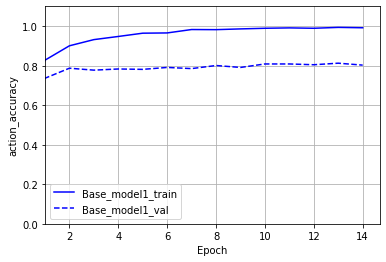

In [25]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'action_accuracy')

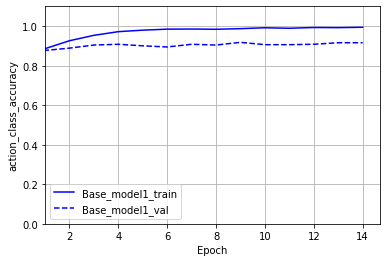

In [26]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'action_class_accuracy')

##Observation
From above graphs it can be seen that the model has achived a good acurracy but it is trying to overfit. to handle it i am going to try out fine tuning.

In [27]:
# VGG16 model performance on test_generator

In [28]:
test_D.shape

(909, 5)

In [29]:
predict = []
predict = base_model_2.predict(testing_generator,verbose=1)

909/909 [==============================] - 30s 32ms/step


In [30]:
predict[0].shape

(909, 21)

In [31]:
action_en_right = test_D['action_en']

In [32]:
action_class_en_right = test_D['action_class_en']

In [34]:
action_predict = predict[0].argmax(axis=1)
action_class_predict = predict[1].argmax(axis=1)

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score ,classification_report
print("action test_generator outcome \n")
print("accuracy score: ", accuracy_score(action_predict,action_en_right))

print(classification_report(action_predict,action_en_right))
# show_conf_metric(action_predict,action_en_right)

print("action_class test_generator outcome \n")
print("accuracy score: ", accuracy_score(action_class_predict,action_class_en_right))

print(classification_report(action_class_predict,action_class_en_right))
# show_conf_metric(action_class_predict,action_class_en_right)

action test_generator outcome 

accuracy score:  0.7733773377337734
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        34
           1       0.93      0.96      0.95        56
           2       0.73      0.71      0.72        58
           3       0.41      0.58      0.48        19
           4       0.93      0.83      0.87        63
           5       0.77      0.77      0.77        30
           6       0.83      0.80      0.81        60
           7       0.48      0.51      0.49        45
           8       0.93      0.82      0.87        65
           9       0.69      0.79      0.73        42
          10       0.97      0.95      0.96        59
          11       0.93      0.93      0.93        59
          12       0.88      0.92      0.90        24
          13       0.78      0.73      0.75        48
          14       0.62      0.91      0.74        23
          15       0.62      0.60      0.61        30
          16 

In [36]:
# 1. from above confusion matric , it can be seen that model has achived good ccuracy and f1 score on test_generator data.
# accuracy for test data acion is 77 and for action_class is 88.
# There is significatinat overfitting as difference between train and testing accuracy is high.accuracy on train data set is nearly 100% for action.
# The macro average F1 score  for action is 74 and foor action_class is 88 on test data which shows our vgg16 model is generalizing well and not bias towards 
#majority classes.




## VGG16 Base Model with fine tuner and image augmentation

In [37]:
#to overcome the overfitting. i am going to use fine tuner with drop out and image augmentation.

In [38]:
#I am going to set some layers frozen, and decided to unfreeze the last block .

In [47]:
#base_model_tune
#Freeze four convolution blocks
from tensorflow.keras.applications import VGG16
base_model_tune = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Make last block of the model trainable:
for layer in base_model_tune.layers[:15]:
    layer.trainable = False

for i, layer in enumerate(base_model_tune.layers):
    print(i, layer.name, layer.trainable)

0 input_6 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [48]:

# x = base_model_tune.output
preprocess_input = tf.keras.applications.vgg16.preprocess_input
inputs = tf.keras.Input(shape=input_shape)

x = preprocess_input(inputs)
x = base_model_tune(x, training=True)
x = tf.keras.layers.Flatten()(x) # Flatten dimensions to for use in FC layers

# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x) # Dropout layer to reduce overfitting
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = tf.keras.layers.Dense(8, activation='softmax')(x) # Softmax for multiclass

# # Add a dropout rate of 0.5
# x = tf.keras.layers.Dropout(0.5)(x)

#custom output dense layer for two classess
output_action = tf.keras.layers.Dense(21, activation='softmax',name='action')(x)
output_action_class = tf.keras.layers.Dense(5, activation='softmax', name = 'action_class')(x)

transfer_model = tf.keras.Model(inputs, outputs=[output_action,output_action_class])

# Make sure you have frozen the correct layers
for i, layer in enumerate(transfer_model.layers):
    print(i, layer.name, layer.trainable)

0 input_7 True
1 tf.__operators__.getitem_2 True
2 tf.nn.bias_add_2 True
3 vgg16 True
4 flatten_2 True
5 action True
6 action_class True


In [49]:
base_model_lr = 0.001 #learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(base_model_lr,decay_steps=10000,decay_rate=10,staircase=False)

transfer_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = lr_schedule),
              loss={
                  'action': "categorical_crossentropy", 
                  'action_class': "categorical_crossentropy"},
              metrics={
                  'action': set_conf_metric('action'),
                  'action_class': set_conf_metric('action_class')})

In [50]:
transfer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 224, 224, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda)   (None, 224, 224, 3)  0           tf.__operators__.getitem_2[0][0] 
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    tf.nn.bias_add_2[0][0]           
____________________________________________________________________________________________

In [51]:
m_histories = {}
m_histories['Base_model_fine_tuner'] = transfer_model.fit(training_generator,
                                                epochs = 15,verbose = 1,
                                                validation_data = validation_generator, callbacks = [early_stop])

Epoch 1/15
49/49 [==============================] - 40s 793ms/step - loss: 5.5677 - action_loss: 3.5455 - action_class_loss: 2.0221 - action_f1_score: 0.1374 - action_accuracy: 0.1703 - action_class_f1_score: 0.4093 - action_class_accuracy: 0.4292 - val_loss: 3.6626 - val_action_loss: 2.4990 - val_action_class_loss: 1.1636 - val_action_f1_score: 0.2230 - val_action_accuracy: 0.2832 - val_action_class_f1_score: 0.5005 - val_action_class_accuracy: 0.5215
Epoch 2/15
49/49 [==============================] - 39s 800ms/step - loss: 3.1268 - action_loss: 2.1525 - action_class_loss: 0.9743 - action_f1_score: 0.3322 - action_accuracy: 0.3820 - action_class_f1_score: 0.6289 - action_class_accuracy: 0.6295 - val_loss: 2.7869 - val_action_loss: 1.9708 - val_action_class_loss: 0.8161 - val_action_f1_score: 0.3623 - val_action_accuracy: 0.4316 - val_action_class_f1_score: 0.7111 - val_action_class_accuracy: 0.7109
Epoch 3/15
49/49 [==============================] - 39s 802ms/step - loss: 2.2903 - ac

In [52]:
#Predictio test data with VGG16 fine tuner

predict = []
predict = transfer_model.predict(testing_generator,verbose=1)


909/909 [==============================] - 29s 32ms/step


In [53]:
action_predict = predict[0].argmax(axis=1)
action_class_predict = predict[1].argmax(axis=1)

In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score ,classification_report
print("action test_generator outcome \n")
print("accuracy score: ", accuracy_score(action_predict,action_en_right))

print(classification_report(action_predict,action_en_right))
# show_conf_metric(action_predict,action_en_right)

print("action_class test_generator outcome \n")
print("accuracy score: ", accuracy_score(action_class_predict,action_class_en_right))

print(classification_report(action_class_predict,action_class_en_right))
# show_conf_metric(action_class_predict,action_class_en_right)

action test_generator outcome 

accuracy score:  0.7161716171617162
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        38
           1       0.86      0.96      0.91        52
           2       0.64      0.64      0.64        56
           3       0.63      0.52      0.57        33
           4       0.91      0.89      0.90        57
           5       0.63      0.53      0.58        36
           6       0.66      0.67      0.66        57
           7       0.60      0.45      0.51        65
           8       0.93      0.93      0.93        57
           9       0.75      0.84      0.79        43
          10       0.97      0.98      0.97        57
          11       0.88      0.90      0.89        58
          12       0.88      0.85      0.86        26
          13       0.69      0.61      0.65        51
          14       0.62      0.81      0.70        26
          15       0.14      0.27      0.18        15
          16 

In [ ]:
#Observations
# 1. from above confusion matrix , it can be seen that Vgg 16 model with fine tuner hasn't achived good accuracy and f1 score on test_generator data.
# accuracy for test data acion is 72 and for action_class is 88.
# It can be ssen that after the fine tuner model has generalised well but still there is
#significatinat overfitting as difference between train and testing accuracy is high.
# The macro average F1 score  for action is 67 and foor action_class is 88 on test data which shows our vgg16-fine tuner model is generalizing well and not bias towards 
#majority classes.
# as we have comapretively small dataset, it is really hard to reduce the overfitting further more. 
# i am going to use another model ResNet50 to see if the overfittig reduction and accruacy can be achieved.

##Base Line Model 2-- ResNet50 with fine tuner and image augmentation

In [79]:
#Model
#Freeze four convolution blocks
from tensorflow.keras.applications import ResNet50
model_ResNet_tune = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Make last block of the conv_base trainable:
for layer in model_ResNet_tune.layers[:165]:
    layer.trainable = False
# for layer in model_ResNet_tune.layers[165:]:
#    layer.trainable = True

# Make sure you have frozen the correct layers
for i, layer in enumerate(model_ResNet_tune.layers):
    print(i, layer.name, layer.trainable)

0 input_12 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_blo

In [85]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
inputs = tf.keras.Input(shape=input_shape)

x = preprocess_input(inputs)
x = model_ResNet_tune(x, training=True)
x = tf.keras.layers.Flatten()(x) # Flatten dimensions to for use in FC layers

# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

#custom output dense layer for two classess
output_action = tf.keras.layers.Dense(21, activation='softmax',name='action')(x)
output_action_class = tf.keras.layers.Dense(5, activation='softmax', name = 'action_class')(x)


model_ResNet = tf.keras.Model(inputs, outputs=[output_action,output_action_class])

# Make sure you have frozen the correct layers
for i, layer in enumerate(model_ResNet.layers):
    print(i, layer.name, layer.trainable)

0 input_16 True
1 tf.__operators__.getitem_8 True
2 tf.nn.bias_add_8 True
3 resnet50 True
4 flatten_8 True
5 dropout_8 True
6 action True
7 action_class True


In [86]:
base_model_lr = 0.001    #learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(base_model_lr,decay_steps=10000,decay_rate=10,staircase=False)

model_ResNet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = lr_schedule),
              loss={
                  'action': "categorical_crossentropy", 
                  'action_class': "categorical_crossentropy"},
              metrics={
                  'action': set_conf_metric('action'),
                  'action_class': set_conf_metric('action_class')})

In [87]:
m_histories = {}
m_histories['Base_model_fine_tuner'] = model_ResNet.fit(training_generator,
                                                epochs = 50,verbose = 1,
                                                validation_data = validation_generator, callbacks = [early_stop])

Epoch 1/50
49/49 [==============================] - 44s 807ms/step - loss: 4.6342 - action_loss: 2.8990 - action_class_loss: 1.7353 - action_f1_score: 0.4724 - action_accuracy: 0.5102 - action_class_f1_score: 0.7178 - action_class_accuracy: 0.7219 - val_loss: 2.0515 - val_action_loss: 1.2589 - val_action_class_loss: 0.7926 - val_action_f1_score: 0.6797 - val_action_accuracy: 0.7246 - val_action_class_f1_score: 0.8721 - val_action_class_accuracy: 0.8672
Epoch 2/50
49/49 [==============================] - 38s 773ms/step - loss: 1.3547 - action_loss: 0.8828 - action_class_loss: 0.4718 - action_f1_score: 0.7720 - action_accuracy: 0.7978 - action_class_f1_score: 0.8972 - action_class_accuracy: 0.8980 - val_loss: 1.3255 - val_action_loss: 0.8723 - val_action_class_loss: 0.4532 - val_action_f1_score: 0.7760 - val_action_accuracy: 0.7969 - val_action_class_f1_score: 0.8985 - val_action_class_accuracy: 0.8965
Epoch 3/50
49/49 [==============================] - 38s 771ms/step - loss: 0.7334 - ac

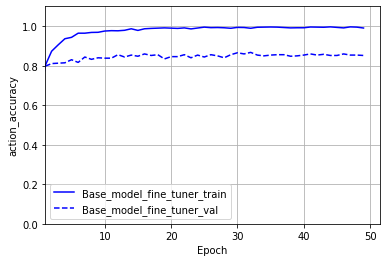

In [88]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'action_accuracy')

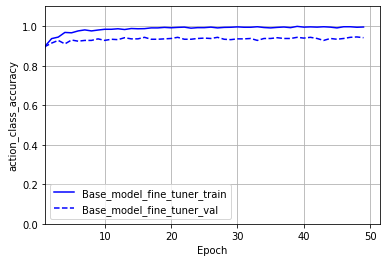

In [89]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'action_class_accuracy')


In [63]:
#From above graphs it can be seen that the ResNet50 model with fine tuner has achived a good acurracy with some overfitting.


In [ ]:
# ResNet50 with fine tuner on testdata

In [90]:
predict = []
predict = model_ResNet.predict(testing_generator,verbose=1)

909/909 [==============================] - 20s 21ms/step


In [91]:
action_predict = predict[0].argmax(axis=1)
action_class_predict = predict[1].argmax(axis=1)

In [92]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score ,classification_report
print("action test_generator outcome \n")
print("accuracy score: ", accuracy_score(action_predict,action_en_right))

print(classification_report(action_predict,action_en_right))
# show_conf_metric(action_predict,action_en_right)

print("action_class test_generator outcome \n")
print("accuracy score: ", accuracy_score(action_class_predict,action_class_en_right))

print(classification_report(action_class_predict,action_class_en_right))
# show_conf_metric(action_class_predict,action_class_en_right)

action test_generator outcome 

accuracy score:  0.7645764576457645
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        29
           1       0.97      0.98      0.97        57
           2       0.70      0.78      0.74        50
           3       0.48      0.62      0.54        21
           4       0.95      0.85      0.90        62
           5       0.73      0.81      0.77        27
           6       0.95      0.71      0.81        77
           7       0.46      0.51      0.48        43
           8       0.82      0.89      0.85        53
           9       0.65      0.82      0.72        38
          10       0.93      0.95      0.94        57
          11       0.88      0.96      0.92        54
          12       0.92      0.96      0.94        24
          13       0.73      0.69      0.71        48
          14       0.74      0.81      0.77        31
          15       0.41      0.48      0.44        25
          16 

In [ ]:
###Conclusion

# From the above graph it can be seen that we have achived good accuracy on our test set with ResNet50 model with fine tuner and dropout.
# The accuracy of action for test set is 76 and for action_class is 88.
# The amount of overfitting is reduced significantly by adding drop out.
# still there is siginificant overfitting in our model. 
# the mircro weighted F1 score for test action is 74 and for action_class is 88.

In [93]:
model_ResNet.save("model_ResNet")
!cp -R ./model_ResNet /content/drive/MyDrive/A1_data

INFO:tensorflow:Assets written to: model_ResNet/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [94]:
#testing ResNet50 with fine tuner on unseen/actual data
# test_data test_data
test_data.head()

,FileName
0,Img_1005.jpg
1,Img_1012.jpg
2,Img_1014.jpg
3,Img_1015.jpg
4,Img_102.jpg


In [99]:
test_data['action_en']=0
test_data['action_class_en']=0
test_data.head()

,FileName,action_en,action_class_en
0,Img_1005.jpg,0,0
1,Img_1012.jpg,0,0
2,Img_1014.jpg,0,0
3,Img_1015.jpg,0,0
4,Img_102.jpg,0,0


In [100]:
prediction_csv = pd.read_csv('/content/drive/MyDrive/A1_data/s1234567_predictions.csv')

In [101]:
prediction_csv.head()

,FileName,action,action_class
0,Img_1005.jpg,shooting_an_arrow,other_activity
1,Img_1012.jpg,shooting_an_arrow,other_activity
2,Img_1014.jpg,shooting_an_arrow,other_activity
3,Img_1015.jpg,shooting_an_arrow,other_activity
4,Img_102.jpg,shooting_an_arrow,other_activity


In [103]:
test_unseen_generator = DataGenerator(test_data, batch_size=1, shuffle=False, Augment = False, data_prefix=prefix)

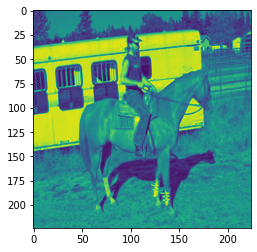

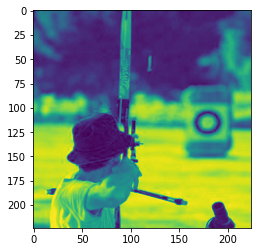

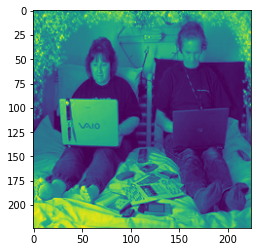

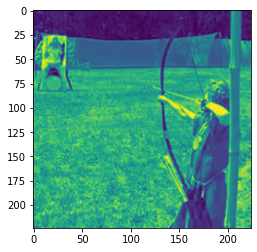

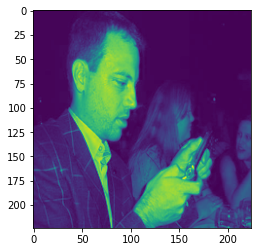

In [138]:
i=0
for x,y in test_unseen_generator.__iter__():
  if i < 5:
    plt.imshow(x[0,:,:,0])
    plt.pause(.1)
    i+=1
  else:
    break

In [126]:
predict = []
predict = model_ResNet.predict(test_unseen_generator,verbose=1)

2100/2100 [==============================] - 44s 21ms/step


In [129]:
action_predict = predict[0].argmax(axis=1)
action_class_predict = predict[1].argmax(axis=1)

In [128]:
action_predict[0]

11

In [130]:
action_outcome = actionEncoder.inverse_transform(action_predict)
action_class_outcome = action_classEncoder.inverse_transform(action_class_predict)

In [133]:
prediction_csv['action']= action_outcome
prediction_csv['action_class']= action_class_outcome

In [135]:
prediction_csv

,FileName,action,action_class
0,Img_1005.jpg,riding_a_horse,Interacting_with_animal
1,Img_1012.jpg,shooting_an_arrow,other_activity
2,Img_1014.jpg,playing_violin,using_comm_device
3,Img_1015.jpg,shooting_an_arrow,other_activity
4,Img_102.jpg,texting_message,using_comm_device
...,...,...,...
2095,Img_985.jpg,riding_a_horse,Interacting_with_animal
2096,Img_986.jpg,running,other_activity
2097,Img_993.jpg,feeding_a_horse,using_comm_device
2098,Img_994.jpg,using_a_computer,domestic_work


In [137]:
prediction_csv.to_csv('/content/drive/MyDrive/prediction1.csv')